In [ ]:
import pandas as pd
url = "https://raw.githubusercontent.com/Estadistica2025B/Estadistica2025B/refs/heads/main/Walmart_Sales.csv"
df = pd.read_csv(url)
df = df.dropna()
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [ ]:
df = df.sort_values(by='Date')

In [ ]:
df.Store.unique()

array([ 1, 10, 37, 17, 30, 25, 22, 23, 24, 19, 21, 26, 39,  8, 32, 15, 34,
       13, 38,  9,  2, 45, 20, 27, 41,  4, 31, 16, 11, 36, 42,  5, 43, 35,
       28,  6, 33, 44, 18,  3, 12, 29, 40,  7, 14])

In [ ]:
df = df[df['Store'] == 22] # yo elegí la 20, tú elige otra

In [ ]:
df.set_index('Date', inplace=True)

1. Cómo detectar la estacionalidad

Te recomiendo usar descomposición de series de tiempo con Python, sobre todo con statsmodels.tsa.seasonal.seasonal_decompose. Este método separa tus datos en tres componentes: tendencia, estacionalidad y residuo.


Pasos generales:

Asegúrate de tener tus datos con un índice de tiempo (fechas) en Pandas.

Decide cuál es tu periodo de estacionalidad (period). Por ejemplo, si tus ventas son semanales y piensas que hay un patrón estacional anual, podrías usar un period = 52 para semanas.

Usa seasonal_decompose(serie, model='additive' o 'multiplicative', period=…).

Analiza el componente .seasonal: ese te mostrará el patrón estacional que se repite.

Para confirmar estacionalidad, también puedes usar gráficos de autocorrelación (ACF): picos en lags regulares indican estacionalidad.

Primer variable "Weekly_Sales"

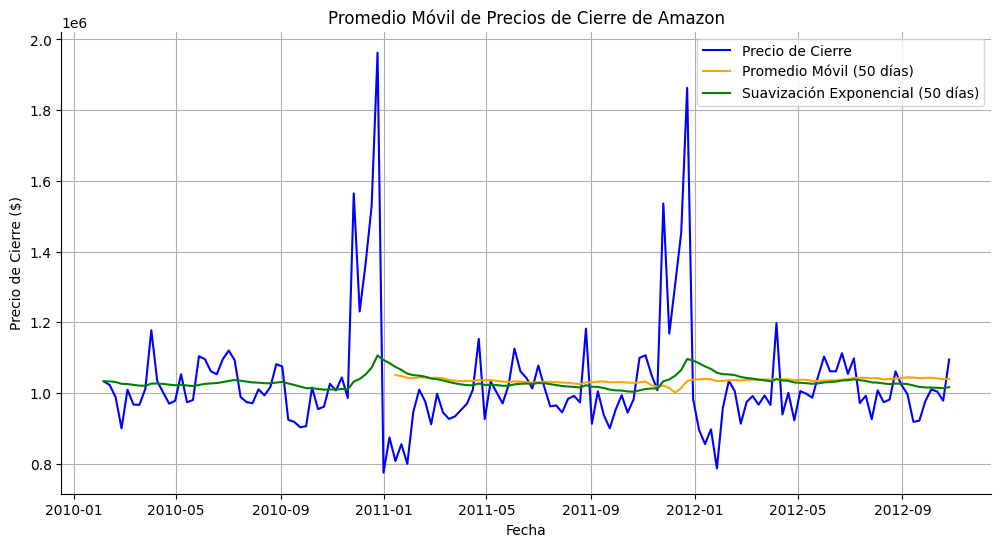

In [ ]:
# Promedio Móvil Simple
import matplotlib.pyplot as plt
ventana_sma = 50
df['SMA'] = df['Weekly_Sales'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 50
df['SES'] = df['Weekly_Sales'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['Weekly_Sales'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title("Promedio Móvil de Precios de Cierre de Amazon")
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Dickey Fuller

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['Weekly_Sales'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -6.13813900845378
p-value: 8.092841588352181e-08
La tendencia es estacionaria (rechazamos la hipótesis nula).


Regresion polinomial

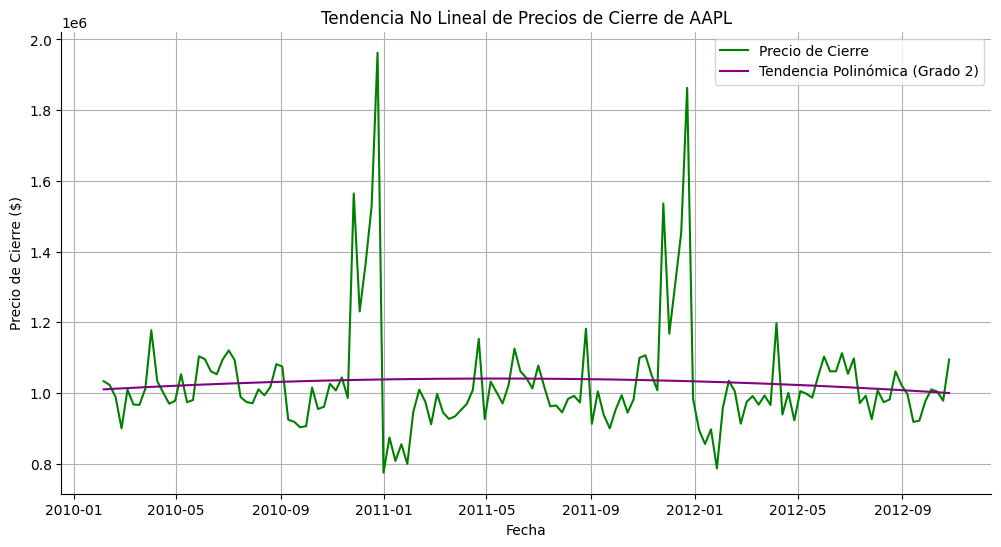

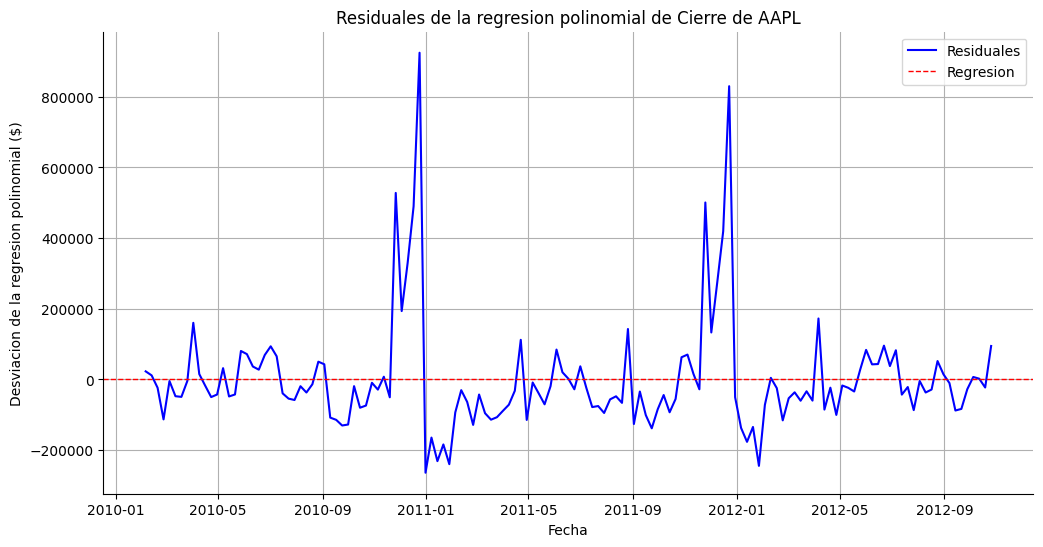

In [ ]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['Weekly_Sales']

# Paso 3: Ajustar un modelo polinómico
grado = 2
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico, termino):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal
      if i == termino:
          df["seasonal_poly"] = componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

Prueba de estacionariedad en los residuales

Frecuencias principales:
    frecuencia      magnitud  longitud_de_onda
0    0.041958  5.158278e+06         23.833333
1    0.034965  4.817370e+06         28.600000
2    0.076923  4.673540e+06         13.000000
3    0.055944  4.062190e+06         17.875000
4    0.111888  3.978173e+06          8.937500


/tmp/ipython-input-3634185557.py:34: RuntimeWarning: divide by zero encountered in divide
  'longitud_de_onda': 1 / frecuencias


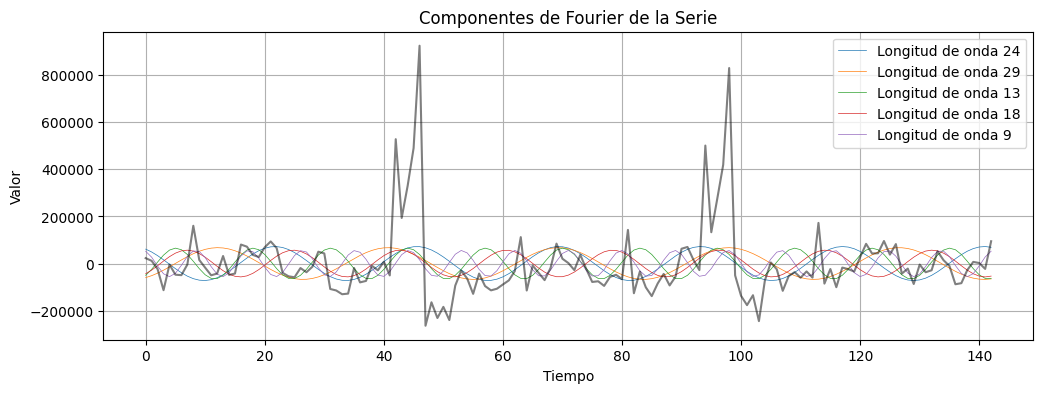

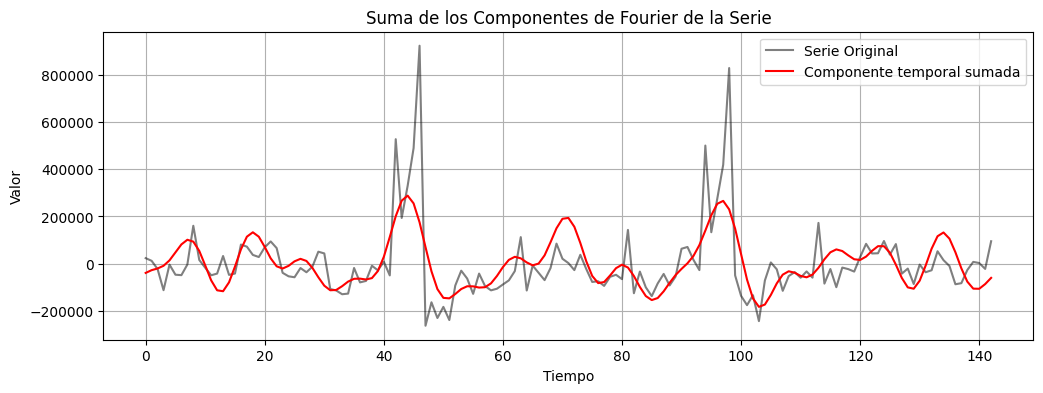

In [ ]:
serie = df['Poly_Resid'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico, 2)

# cts: componente temporal sumado

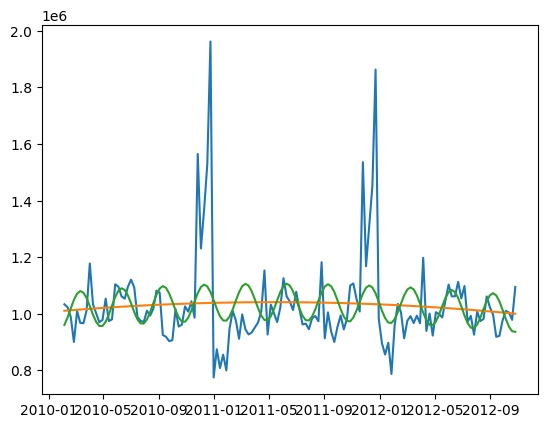

In [ ]:
plt.plot(df["Weekly_Sales"])
plt.plot(df["Poly_Trend"])
plt.plot(df["Poly_Trend"] + df['seasonal_poly'])

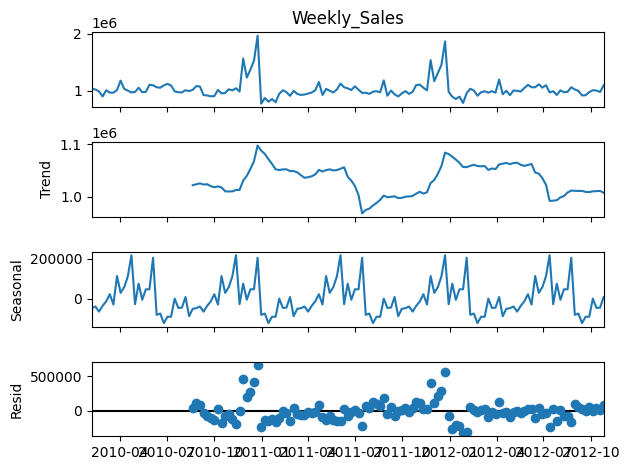

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['Weekly_Sales'],
    model='additive',
    period=29,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

2. Posibles resultados y conclusiones para cada variable

Voy variable por variable, con lo que podrías esperar y cómo interpretar la estacionalidad (si la hay), y ejemplos de interpretación.

Weekly Sales (ventas semanales)

Qué podría pasar: Es muy probable que haya estacionalidad. Por ejemplo, ventas más altas en ciertas épocas del año (temporada navideña, vacaciones) o incluso patrones semanales (si algunos días de la semana se venden más, aunque estás agregando a nivel semanal, pero puede haber ciclos anuales).

Interpretación si hay estacionalidad: Si tu descomposición muestra una componente estacional clara (por ejemplo, subidas cada 52 semanas en ciertos puntos), eso significa que las ventas tienen un patrón recurrente anual. Puedes usar esos índices estacionales para ajustar tus previsiones o para hacer estrategias de marketing en temporadas altas.

Conclusión posible: “La variable de ventas semanales presenta un patrón estacional anual: hay picos en ciertas semanas del año, lo cual sugiere que parte de las variaciones de venta se deben a ciclos estacionales, no solo a tendencias o ruido.


Segunda variable "Temperature"

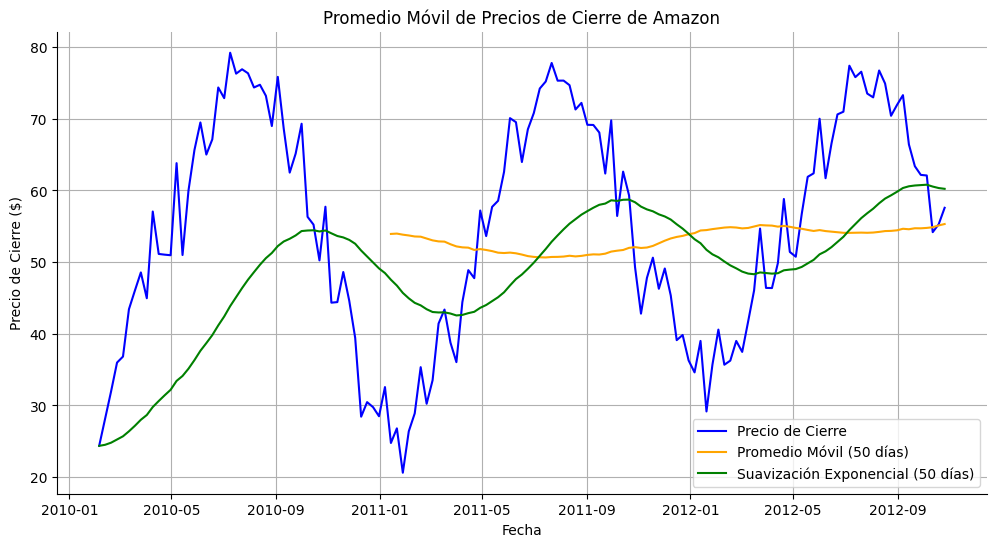

In [ ]:
# Promedio Móvil Simple
import matplotlib.pyplot as plt
ventana_sma = 50
df['SMA'] = df['Temperature'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 50
df['SES'] = df['Temperature'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['Temperature'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title("Promedio Móvil de Precios de Cierre de Amazon")
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['Temperature'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -6.243768302610975
p-value: 4.629020246305021e-08
La tendencia es estacionaria (rechazamos la hipótesis nula).


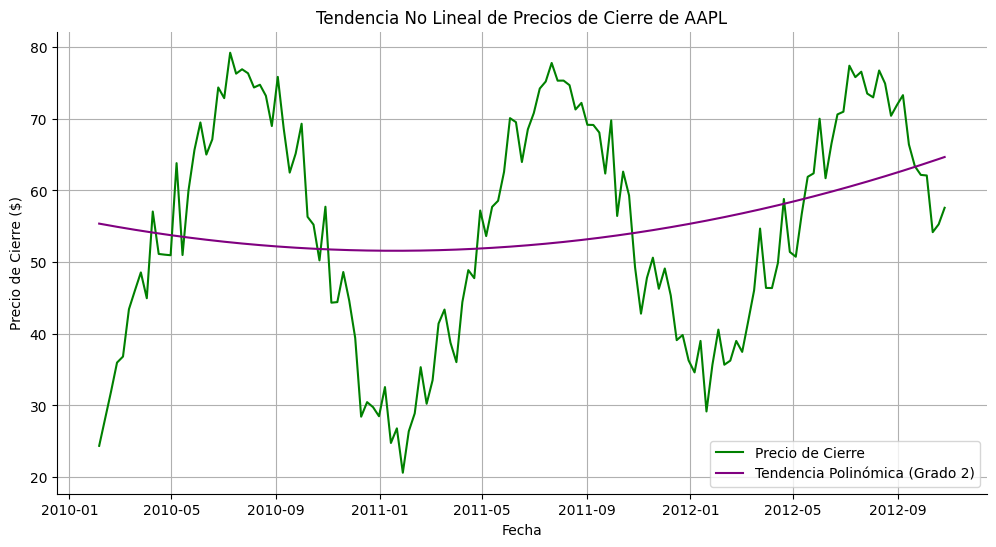

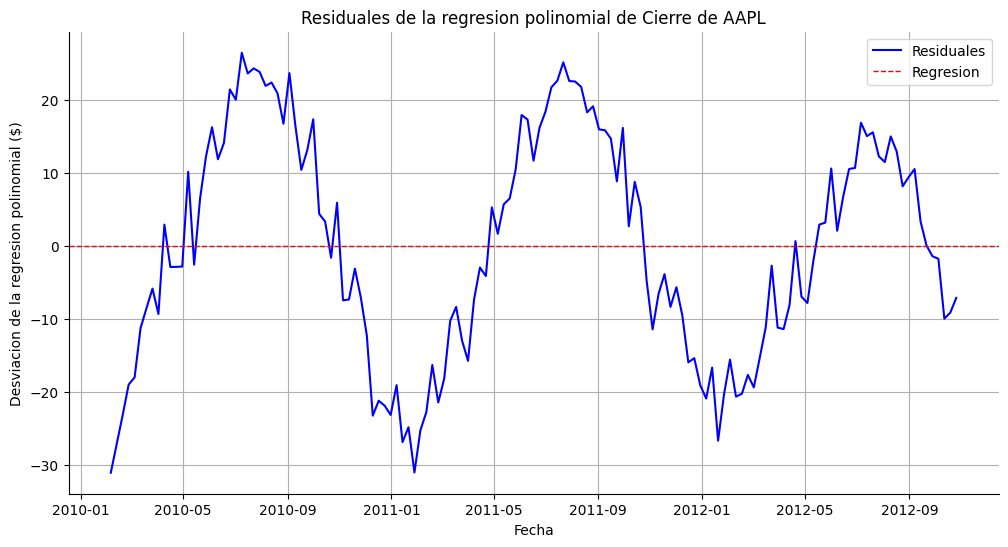

In [ ]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['Temperature']

# Paso 3: Ajustar un modelo polinómico
grado = 2
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico, termino):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal
      if i == termino:
          df["seasonal_poly"] = componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

Frecuencias principales:
    frecuencia     magnitud  longitud_de_onda
0    0.020979  1324.778967         47.666667
1    0.013986   572.764500         71.500000
2    0.027972   235.395896         35.750000
3    0.006993   165.470890        143.000000
4    0.041958   128.023486         23.833333


/tmp/ipython-input-3634185557.py:34: RuntimeWarning: divide by zero encountered in divide
  'longitud_de_onda': 1 / frecuencias


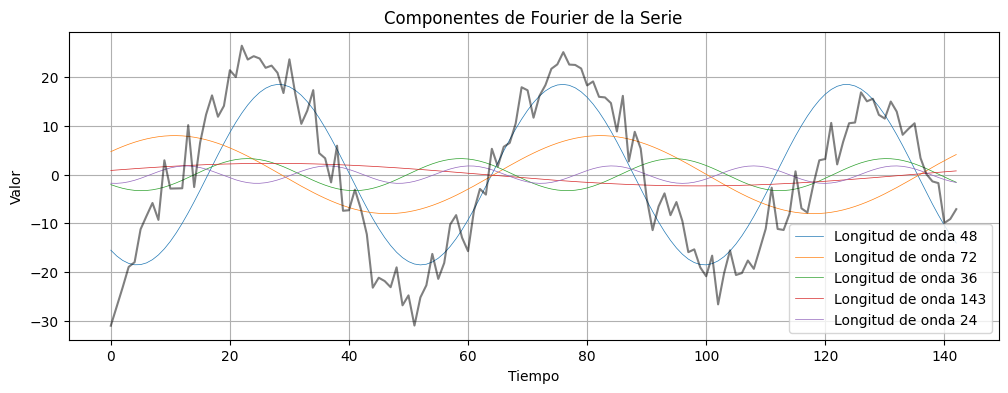

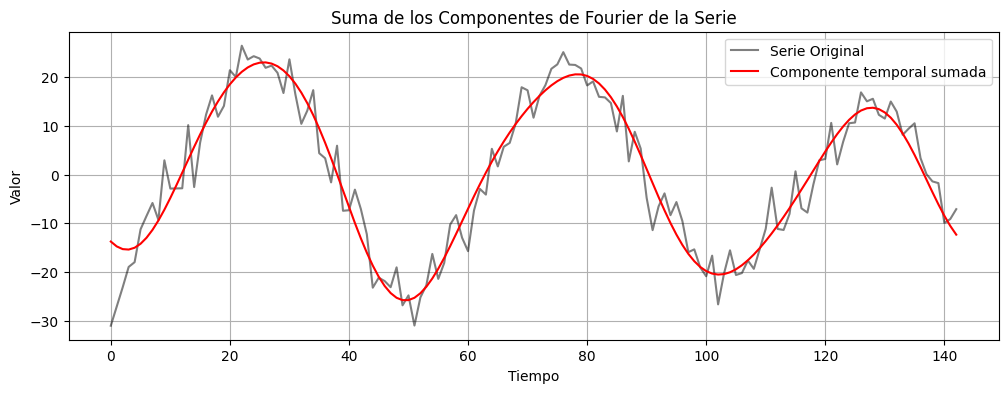

In [ ]:
serie = df['Poly_Resid'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico, 2)

# cts: componente temporal sumado

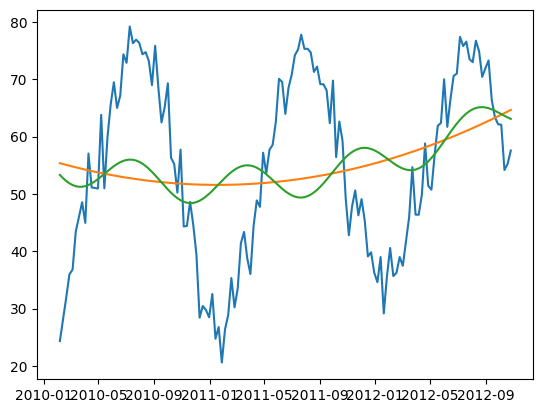

In [ ]:
plt.plot(df["Temperature"])
plt.plot(df["Poly_Trend"])
plt.plot(df["Poly_Trend"] + df['seasonal_poly'])

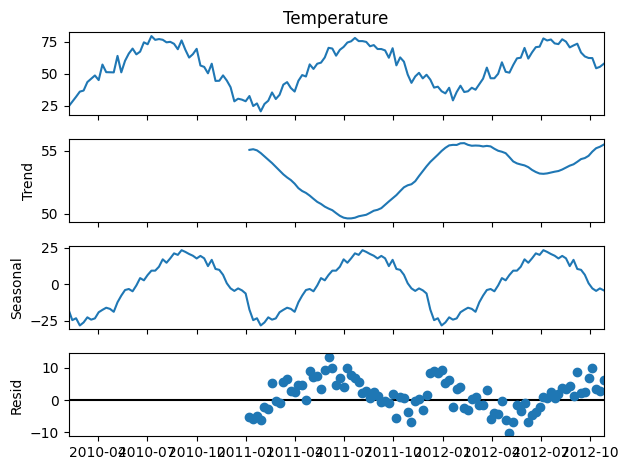

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['Temperature'],
    model='additive',
    period=48,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

Temperature (temperatura)

Qué podría pasar: Muy probablemente tenga estacionalidad, especialmente si tus datos abarcan varios años. La temperatura tiene un ciclo estacional muy fuerte (verano vs invierno).

Interpretación: Si descompones la serie de temperatura, probablemente obtendrás una clara componente estacional con periodos anuales (por ejemplo, pico en verano y valle en invierno). La amplitud de esa componente te dice cuánto varía la temperatura por estación.

Conclusión posible: “La temperatura muestra una fuerte estacionalidad anual, lo cual es esperado: las variaciones de la temperatura dependen mucho de la estación del año. Esto puede correlacionar con otros factores estacionales en las ventas.”

Cuarta variable "Fuel_Price"

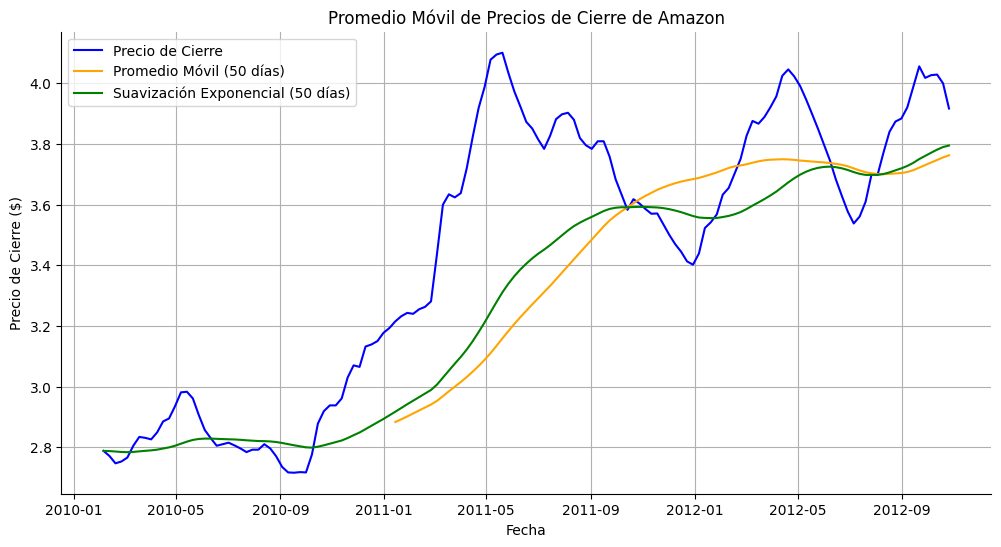

In [ ]:
# Promedio Móvil Simple
import matplotlib.pyplot as plt
ventana_sma = 50
df['SMA'] = df['Fuel_Price'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 50
df['SES'] = df['Fuel_Price'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['Fuel_Price'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title("Promedio Móvil de Precios de Cierre de Amazon")
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['Fuel_Price'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -1.7386942662030132
p-value: 0.4112943138922301
La tendencia no es estacionaria (aceptamos la hipótesis nula).


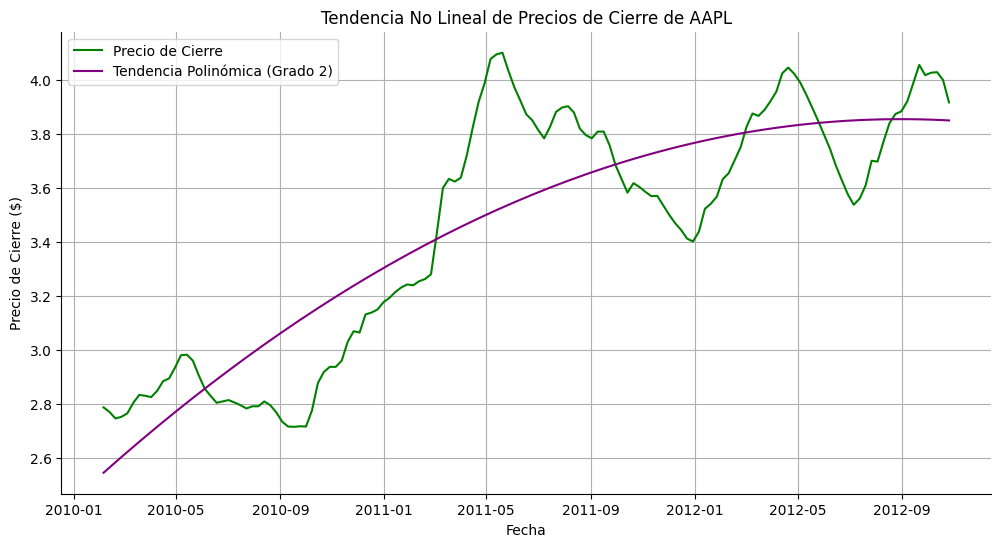

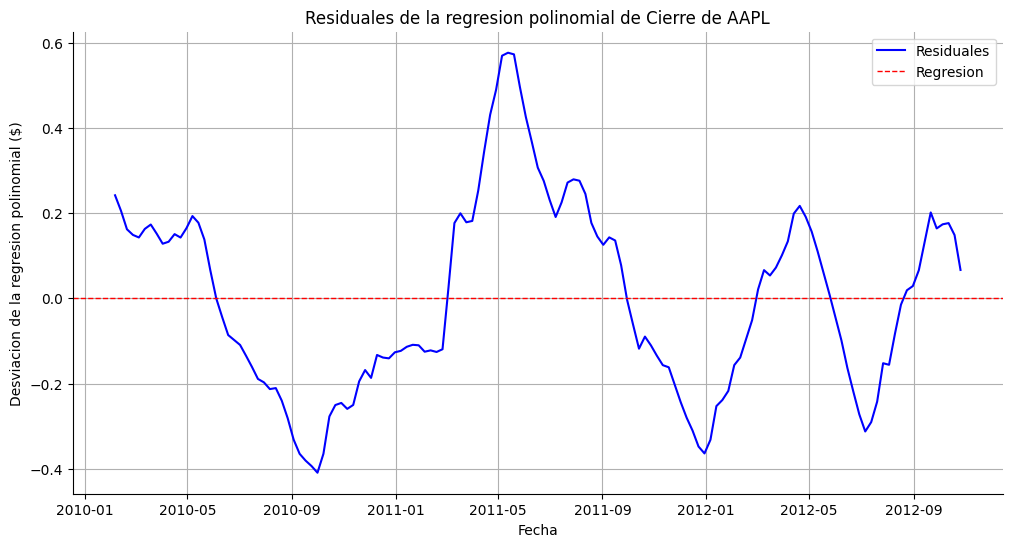

In [ ]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['Fuel_Price']

# Paso 3: Ajustar un modelo polinómico
grado = 2
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico, termino):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal
      if i == termino:
          df["seasonal_poly"] = componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

Frecuencias principales:
    frecuencia   magnitud  longitud_de_onda
0    0.006993  35.049954        143.000000
1    0.013986  21.623155         71.500000
2    0.041958  11.643276         23.833333
3    0.020979   7.503048         47.666667
4    0.034965   6.271222         28.600000


/tmp/ipython-input-3634185557.py:34: RuntimeWarning: divide by zero encountered in divide
  'longitud_de_onda': 1 / frecuencias


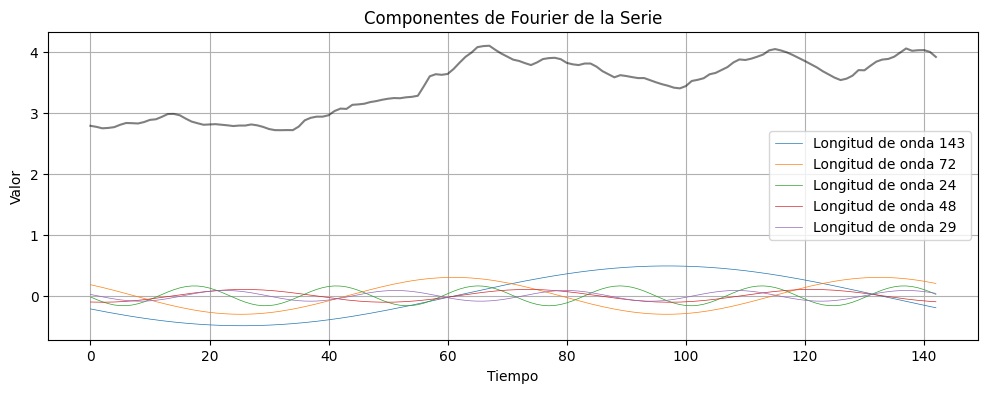

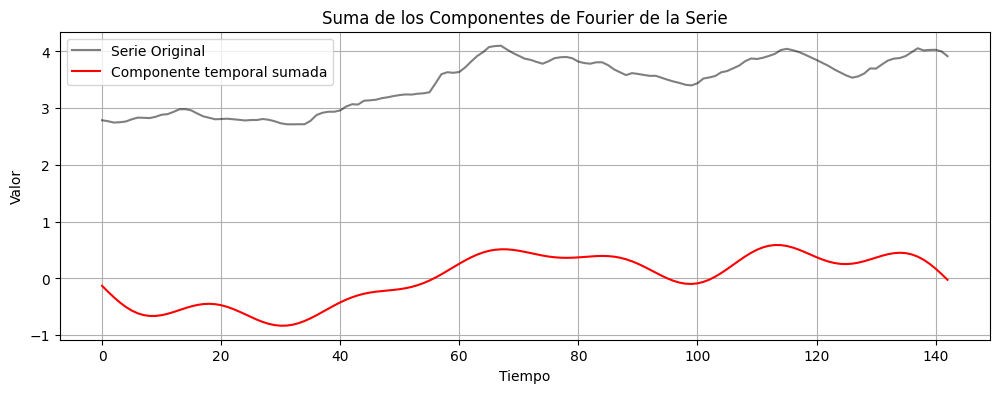

In [ ]:
serie = df['Fuel_Price'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico, 2)

# cts: componente temporal sumado

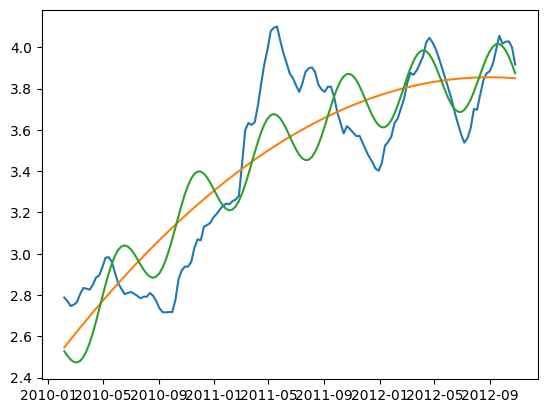

In [ ]:
plt.plot(df["Fuel_Price"])
plt.plot(df["Poly_Trend"])
plt.plot(df["Poly_Trend"] + df['seasonal_poly'])

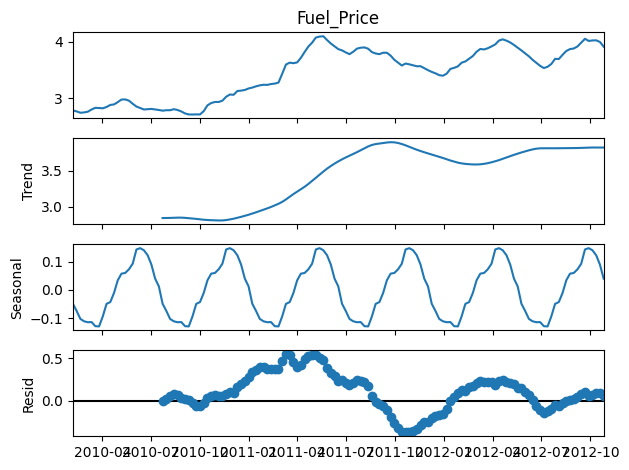

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['Fuel_Price'],
    model='additive',
    period=24,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

Fuel Price (precio del combustible)

Qué podría pasar: Puede tener estacionalidad, pero no necesariamente tan evidente como las ventas o la temperatura, depende del mercado y del país. Por ejemplo, puede subir en verano si hay más demanda por viajes o bajar según regulaciones.

Interpretación: Si el componente estacional existe y es significativo, podría mostrar picos recurrentes en ciertas épocas (vacacionales, estaciones de alta demanda). Si no hay un patrón muy marcado, la componente estacional puede ser muy baja comparada con la tendencia o el ruido.

Conclusión posible: “El precio del combustible tiene una estacionalidad débil/moderada: aunque hay cierta repetición anual (o estacional), la variación no es tan robusta como en las ventas o la temperatura, lo que sugiere que otros factores (geopolíticos, económicos) dominan más que solo la estacionalidad.”

Tercera variable "CPI"


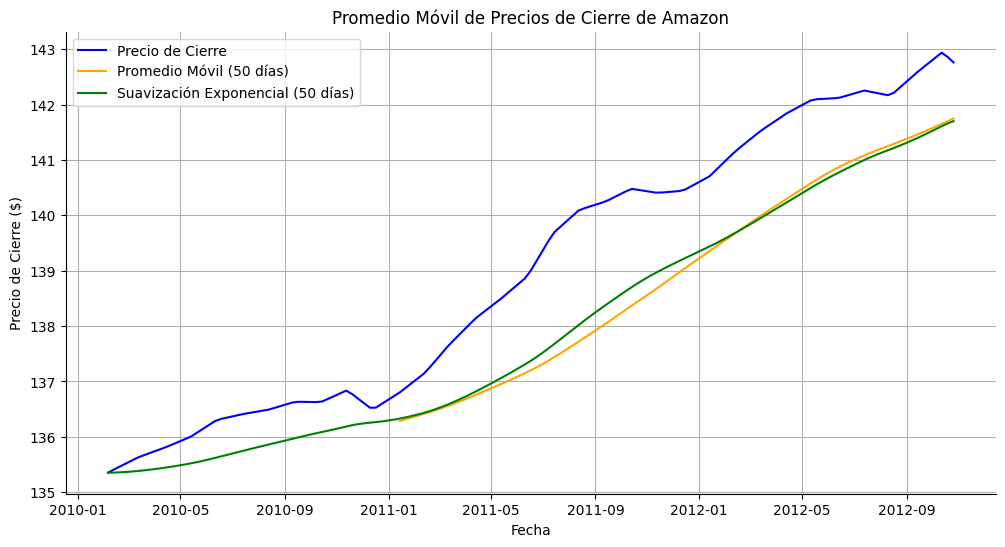

In [ ]:
# Promedio Móvil Simple
import matplotlib.pyplot as plt
ventana_sma = 50
df['SMA'] = df['CPI'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 50
df['SES'] = df['CPI'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['CPI'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title("Promedio Móvil de Precios de Cierre de Amazon")
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['CPI'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -0.7612740162122894
p-value: 0.8302337775532156
La tendencia no es estacionaria (aceptamos la hipótesis nula).


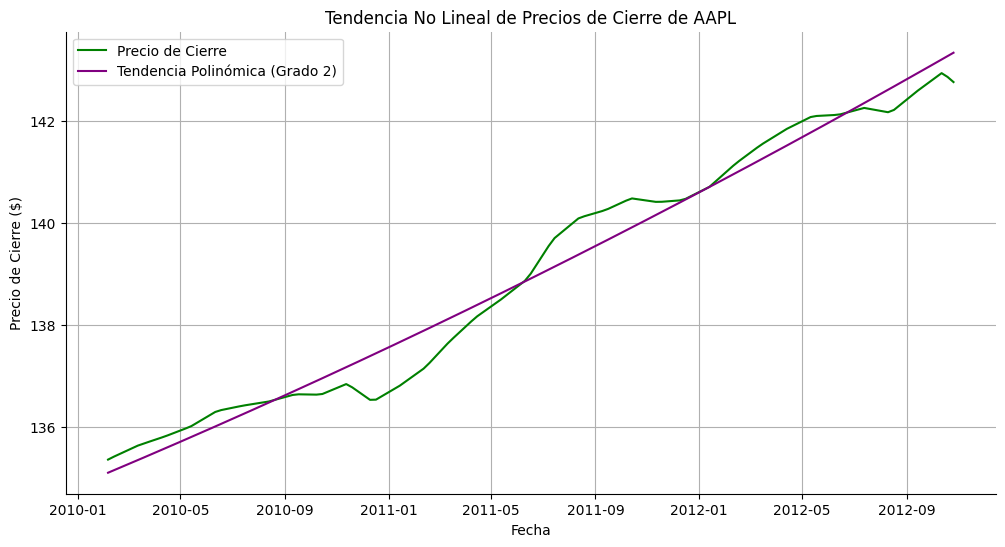

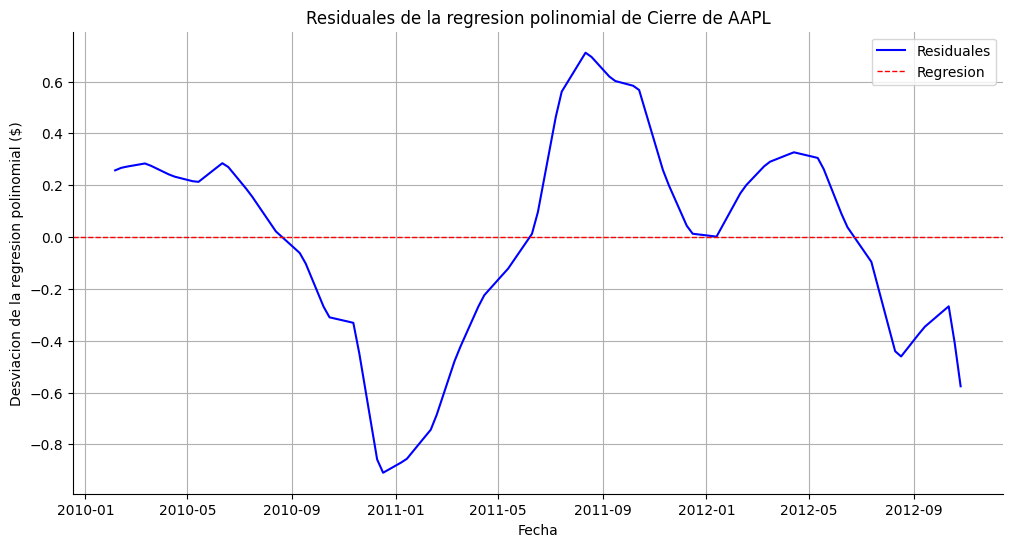

In [ ]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['CPI']

# Paso 3: Ajustar un modelo polinómico
grado = 2
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico, termino):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal
      if i == termino:
          df["seasonal_poly"] = componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

/tmp/ipython-input-3634185557.py:34: RuntimeWarning: divide by zero encountered in divide
  'longitud_de_onda': 1 / frecuencias


Frecuencias principales:
    frecuencia    magnitud  longitud_de_onda
0    0.006993  208.074728        143.000000
1    0.013986   68.355607         71.500000
2    0.020979   65.205031         47.666667
3    0.027972   37.051810         35.750000
4    0.034965   34.757698         28.600000


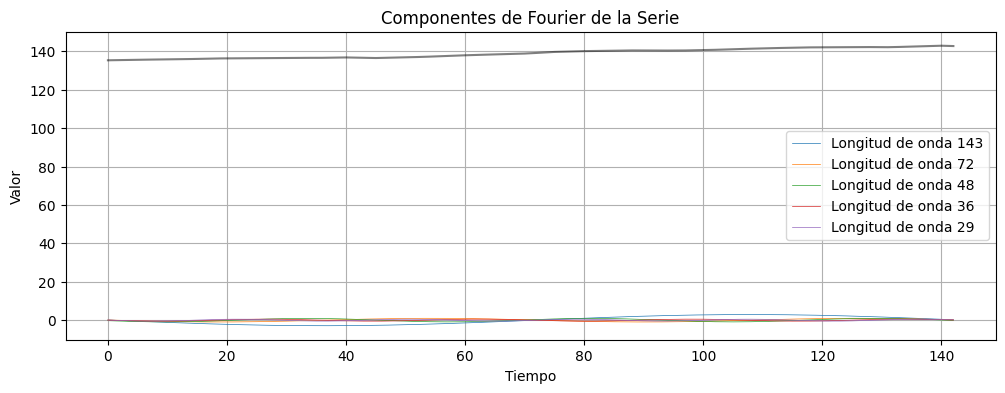

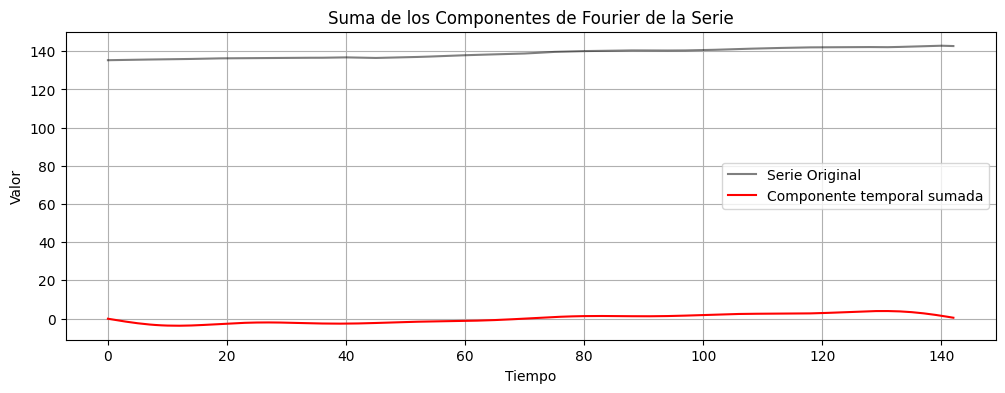

In [ ]:
serie = df['CPI'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico, 2)

# cts: componente temporal sumado

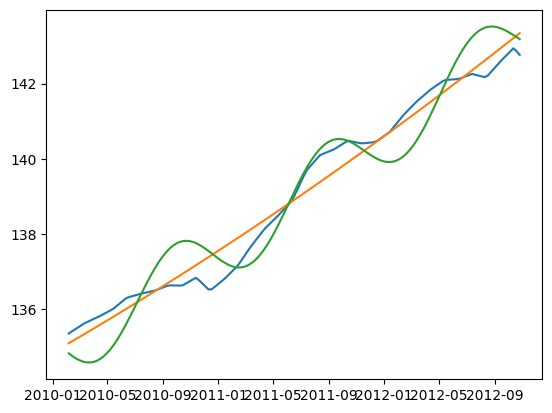

In [ ]:
plt.plot(df["CPI"])
plt.plot(df["Poly_Trend"])
plt.plot(df["Poly_Trend"] + df['seasonal_poly'])

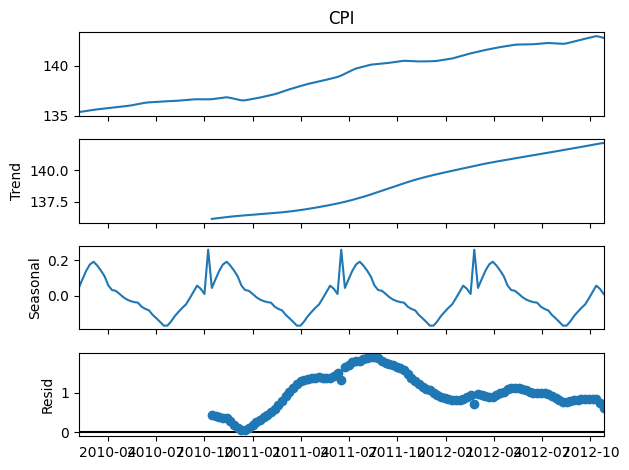

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['CPI'],
    model='additive',
    period=36,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

CPI (Índice de Precios al Consumidor)

Qué podría pasar: El CPI puede tener estacionalidad en ciertos componentes (como precios de alimentos, energía), pero el índice agregado podría tener una estacionalidad más suave.

Interpretación: Si hay estacionalidad, significa que ciertos precios (o subíndices) tienen ciclos previsibles (por ejemplo, energéticos más caros en invierno, alimentos en ciertas épocas). Pero la tendencia general (inflación) puede ocultar en parte estos ciclos.

Conclusión posible: “El CPI muestra una leve estacionalidad: ciertos componentes del índice repiten patrones cada año, pero la tendencia principal sigue siendo la inflación o la variabilidad macroeconómica, lo que sugiere que aunque hay un efecto estacional, no es el motor principal del cambio.”

Quinta variable "Unemployment"

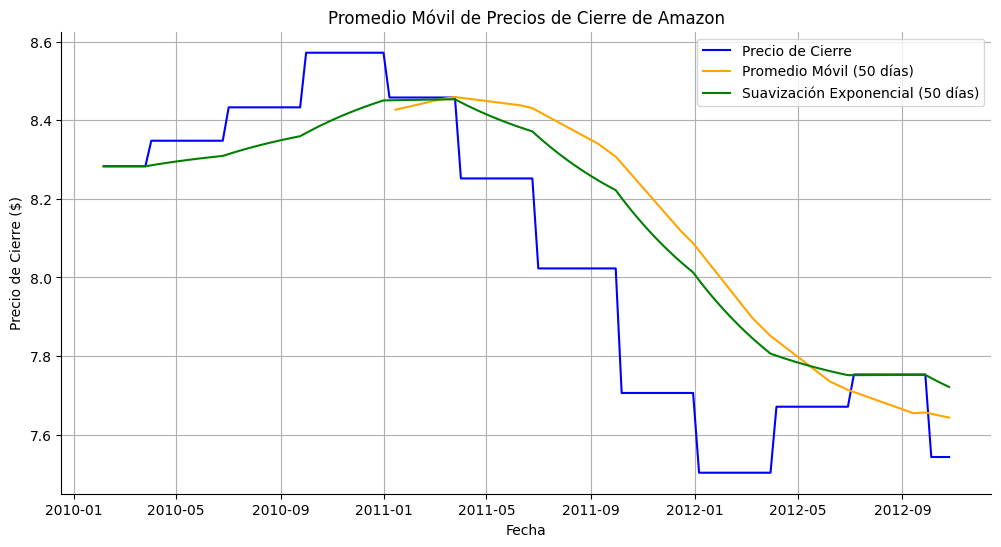

In [ ]:
# Promedio Móvil Simple
import matplotlib.pyplot as plt
ventana_sma = 50
df['SMA'] = df['Unemployment'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 50
df['SES'] = df['Unemployment'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['Unemployment'], label='Precio de Cierre', color='blue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='orange')
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='green')
plt.title("Promedio Móvil de Precios de Cierre de Amazon")
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['Unemployment'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")

Estadístico ADF: -0.2789600017279344
p-value: 0.9284318171168078
La tendencia no es estacionaria (aceptamos la hipótesis nula).


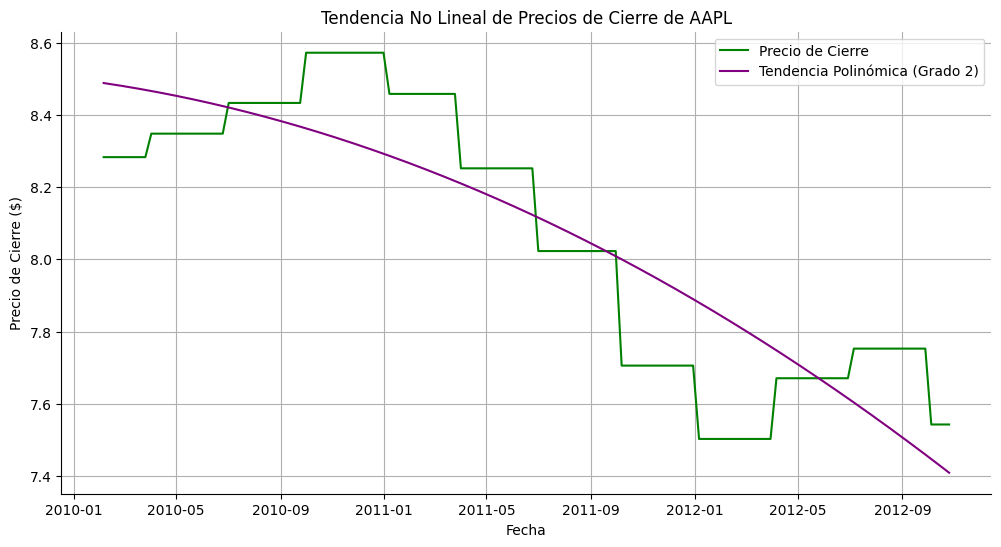

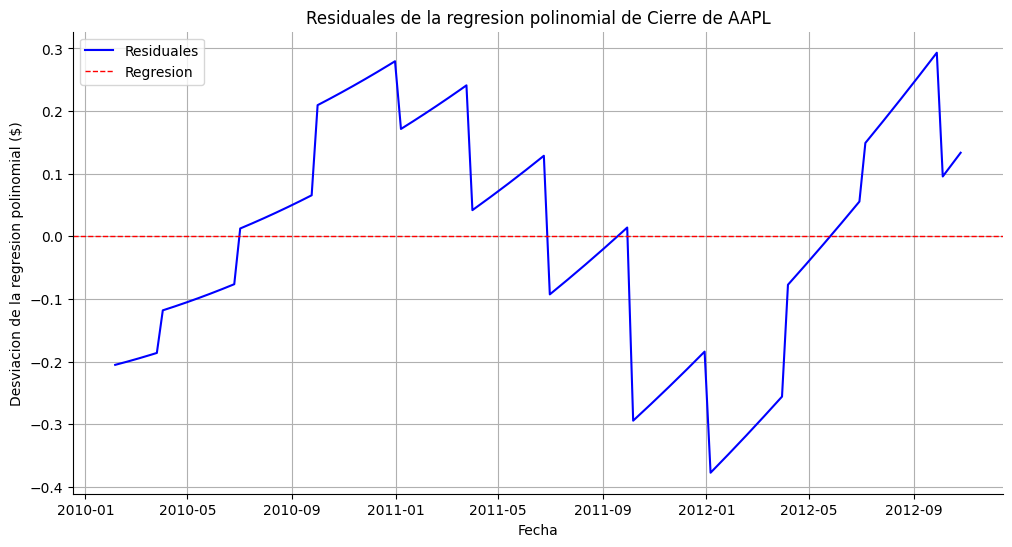

In [ ]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['Unemployment']

# Paso 3: Ajustar un modelo polinómico
grado = 2
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='green'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='purple')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='blue')
plt.axhline(0, color='red', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico, termino):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal
      if i == termino:
          df["seasonal_poly"] = componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='red')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

Frecuencias principales:
    frecuencia   magnitud  longitud_de_onda
0    0.006993  35.434764        143.000000
1    0.027972   5.058004         35.750000
2    0.062937   3.682098         15.888889
3    0.034965   3.475924         28.600000
4    0.055944   2.663674         17.875000


/tmp/ipython-input-3634185557.py:34: RuntimeWarning: divide by zero encountered in divide
  'longitud_de_onda': 1 / frecuencias


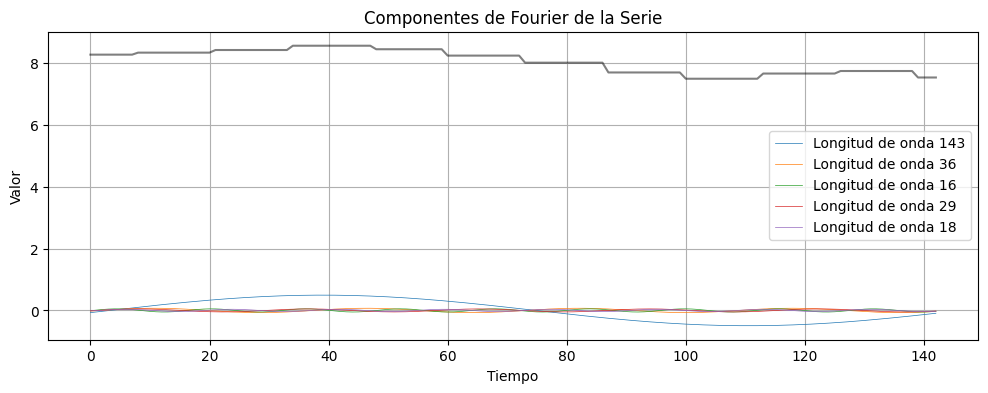

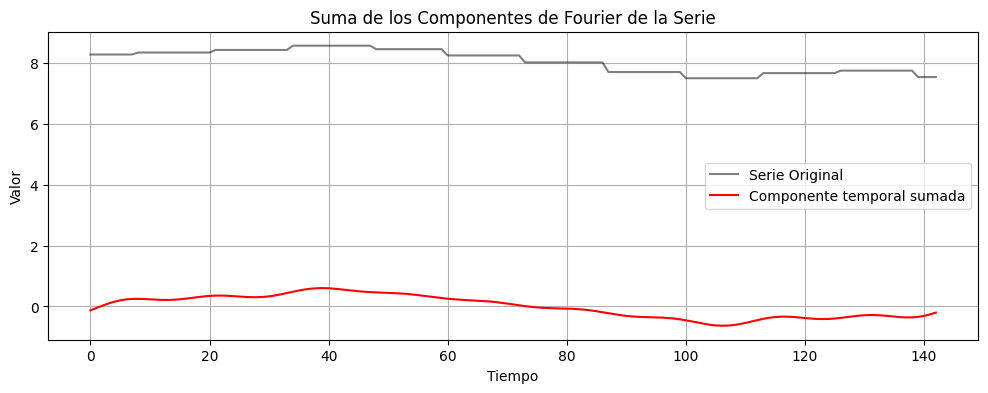

In [ ]:
serie = df['Unemployment'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico, 2)

# cts: componente temporal sumado

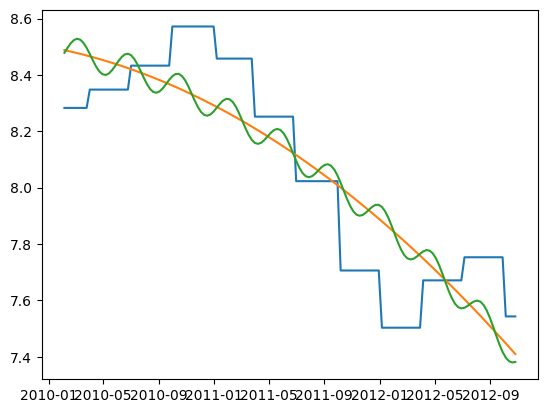

In [ ]:
plt.plot(df["Unemployment"])
plt.plot(df["Poly_Trend"])
plt.plot(df["Poly_Trend"] + df['seasonal_poly'])

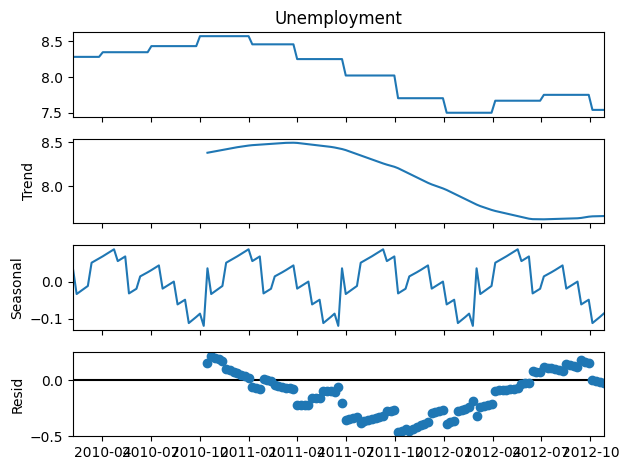

In [ ]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['Unemployment'],
    model='additive',
    period=36,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()

Unemployment (desempleo)

Qué podría pasar: El desempleo también podría tener estacionalidad, dependiendo del país. Por ejemplo, en algunos países hay más empleo en temporadas de turismo, agricultura u otras industrias, lo cual causa variaciones estacionales de desempleo.

Interpretación: Si la descomposición revela una componente estacional, puede haber subidas y bajadas recurrentes en ciertas épocas del año. Si no la hay o es débil, puede significar que el desempleo es más influido por factores estructurales y cíclicos que por estacionalidad simple.

Conclusión posible: “El desempleo tiene una componente estacional moderada: hay momentos del año en que sube o baja de forma regular, lo que puede deberse a empleos temporales o estacionales. Sin embargo, la tendencia subyacente (tal vez macroeconómica) también es muy relevante.”

**Explicación de por qué ocurre la estacionalidad en estos casos**

La estacionalidad es la variación periódica predecible en una serie temporal que se repite cada cierto período.
En economía y datos reales, muchos fenómenos tienen ciclos estacionales (temperatura, consumo, empleo) porque dependen de estaciones del año, clima, comportamientos sociales, vacaciones, ciclos agrícolas, etc.

Al descomponer la serie, separas esos efectos para poder ver la tendencia real (qué tanto crece algo a largo plazo) y el ruido (variabilidad aleatoria).

Además, conocer la estacionalidad te ayuda para pronosticar mejor: si sabes que hay picos estacionales, puedes ajustar tus modelos para aprovechar esos picos o ser más conservador en temporadas bajas.